In [2]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
def apply_g(primals, tangent):

    theta = primals[0]
    orig_shape = tangent.shape
    tangent = tangent.reshape(-1, 2, 1)

    g = jnp.array([[0.5, 0],[0, 2*jnp.sin(theta/2)**2]])
    res = jnp.matmul(g, tangent)
    return res.reshape(orig_shape)

In [4]:
def inverse_g(primals, cotangent):
    A = lambda tangents : apply_g(primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]

In [5]:
def a(primals, gamma_dot):
    f = lambda primals : apply_g(primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def b(primals, gamma_dot):
    f = lambda primals : jnp.sum(gamma_dot * apply_g(primals, gamma_dot))
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@jax.jit
def geodesic_correction(primals, gamma_dot):
    lower = 2 * a(primals, gamma_dot) - b(primals, gamma_dot)
    raised = inverse_g(primals, lower)
    return 0.5*raised

In [6]:
def a_approx(gamma, old_gamma, gamma_dot, epsilon):
    x = apply_g(gamma, gamma_dot) -  apply_g(old_gamma, gamma_dot)
    return x/epsilon


def b_approx(gamma, old_gamma, gamma_dot, epsilon):
    x1 = jnp.sum(gamma_dot * apply_g(gamma, gamma_dot))
    x2 = jnp.sum(gamma_dot * apply_g(old_gamma, gamma_dot))

    tot = (x1 - x2) / epsilon

    norm_gamma_dot = gamma_dot / jnp.sum(gamma_dot**2)

    return tot * apply_g(gamma, norm_gamma_dot)

@jax.jit
def geodesic_correction_approx(gamma, old_gamma, gamma_dot, epsilon):
    lower = 2 * a_approx(gamma, old_gamma, gamma_dot, epsilon) - b_approx(gamma, old_gamma, gamma_dot, epsilon)
    raised = inverse_g(gamma, lower)
    return 0.5*raised

To calculate the energy and its natrural gradient, we use the following:

In [14]:
def calc_E(primals):
    orig_shape = primals.shape
    primals = primals.reshape((-1, 2))

    theta = primals[:,0]
    phi = primals[:,1]


    E = -jnp.sin(theta)*jnp.cos(phi)
    return E.reshape(orig_shape[0:-1])

@jax.jit
def calc_natural_gradient(primals):
    covect = jax.vjp(calc_E, primals)[1](jnp.array(1.))[0]
    return inverse_g(primals, covect)

---

In [15]:
def optimise_momentum(gamma, N_iter = 150, dt = 0.1, kappa = 1.):
    gamma_dot = -calc_natural_gradient(gamma)

    gammas = [gamma - dt * gamma_dot, gamma]
    for i in tqdm(range(2, N_iter)):
        delta_gam = gammas[i - 1] - gammas[i - 2]
        cor = geodesic_correction(gammas[i - 1], delta_gam)
        natural_grad = calc_natural_gradient(gammas[i - 1])
        gamma = gammas[i-1] - dt**2 * natural_grad +  (1 - kappa * dt) * delta_gam - cor
        gammas.append(gamma)

    gammas = jnp.array(gammas)

    return gammas

In [16]:
#
# This one uses the approximated Christoffel Symbols
#
def optimise_momentum_approx(gamma, N_iter = 150, dt = 0.1, kappa = 1.):
    gamma_dot = -calc_natural_gradient(gamma)

    gammas = [gamma - dt * gamma_dot, gamma]
    for i in tqdm(range(2, N_iter)):
        delta_gam = gammas[i - 1] - gammas[i - 2]
        cor = geodesic_correction_approx(gammas[i - 1], gammas[i - 2], delta_gam/dt, dt)
        natural_grad = calc_natural_gradient(gammas[i - 1])
        gamma = gammas[i-1] - dt**2 * natural_grad +  (1 - kappa * dt) * delta_gam - cor*dt**2
        gammas.append(gamma)

    gammas = jnp.array(gammas)

    return gammas

In [17]:
#
# This one does not use any Christoffel symbols
#
def optimise_momentum_approx_approx(gamma, N_iter = 150, dt = 0.1, kappa = 1.):
    gamma_dot = -calc_natural_gradient(gamma)

    gammas = [gamma - dt * gamma_dot, gamma]
    for i in tqdm(range(2, N_iter)):
        delta_gam = gammas[i - 1] - gammas[i - 2]
        # cor = geodesic_correction_approx(gammas[i - 1], gammas[i - 2], delta_gam/dt, dt)
        natural_grad = calc_natural_gradient(gammas[i - 1])
        gamma = gammas[i-1] - dt**2 * natural_grad +  (1 - kappa * dt) * delta_gam
        gammas.append(gamma)

    gammas = jnp.array(gammas)

    return gammas

In [18]:
def optimise_natural_grad(gamma, N_iter = 150, dt = 0.1):
    gammas = [gamma]
    for i in tqdm(range(1, N_iter)):
        natural_grad = calc_natural_gradient(gammas[i - 1])
        gamma = gammas[i-1] - dt * natural_grad
        gammas.append(gamma)

    gammas = jnp.array(gammas)

    return gammas

In [40]:
dt = 0.05
gamma0 = jnp.array([0.6,1.])
kappa = (1 - 0.9)/dt
N_iter = 900
iter = jnp.arange(N_iter)

gammas_moment = optimise_momentum(gamma0, N_iter, dt = dt, kappa = kappa)
gammas_moment_approx = optimise_momentum_approx(gamma0, N_iter, dt = dt, kappa = kappa)
gammas_moment_approx_approx = optimise_momentum_approx_approx(gamma0, N_iter, dt = dt, kappa = kappa)
gammas_nat = optimise_natural_grad(gamma0, N_iter, dt = dt)

E_moment = calc_E(gammas_moment)
E_moment_approx = calc_E(gammas_moment_approx)
E_moment_approx_approx = calc_E(gammas_moment_approx_approx)
E_nat = calc_E(gammas_nat)

100%|██████████| 899/899 [00:00<00:00, 44022.73it/s]


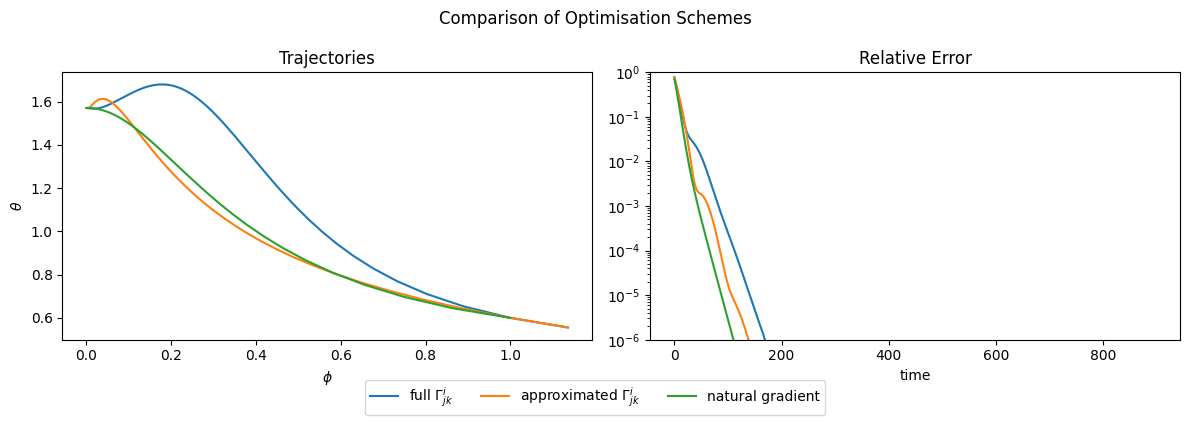

In [41]:
f, axs = plt.subplots(1,2, figsize = (12,4))

axs[0].plot(gammas_moment[:, 1], gammas_moment[:, 0], label = "full $\\Gamma^i_{jk}$")
axs[0].plot(gammas_moment_approx[:, 1], gammas_moment_approx[:, 0], label = "approximated $\\Gamma^i_{jk}$")
axs[0].plot(gammas_nat[:, 1], gammas_nat[:, 0], label = "natural gradient")
# axs[0].plot(gammas_moment_approx_approx[:, 1], gammas_moment_approx_approx[:, 0], label = "no $\\Gamma^i_{jk}$ ")

# axs[0].scatter(0, jnp.pi/2, color = "C3", marker = "o", zorder = 10)
# axs[0].set_ylim(0, jnp.pi)
# axs[0].set_xlim(-jnp.pi/3, 2/3*jnp.pi)
axs[0].set_ylabel("$\\theta$")
axs[0].set_xlabel("$\\phi$")
# axs[0].legend()
axs[0].set_title("Trajectories")


axs[1].plot(iter, E_moment + 1)
axs[1].plot(iter, E_moment_approx + 1)
axs[1].plot(iter, E_nat + 1)
# axs[1].plot(iter, E_moment_approx_approx + 1)
axs[1].set_yscale("log")

axs[1].set_yscale("log")
axs[1].set_title("Relative Error")
axs[1].set_ylim(1e-6,1)
axs[1].set_xlabel("time")

handles, labels = axs[0].get_legend_handles_labels()
f.legend(handles, labels, loc="lower center", ncol = 4, bbox_to_anchor = (0, -0.05, 1, 1))
f.suptitle("Comparison of Optimisation Schemes")

f.tight_layout()